In [2]:
import tensorflow as tf
print("tensorflow version " + str(tf.__version__)) # tested on 2.4.1
import tensorflow_addons as tfa
print("tensorflow-addons version " + str(tfa.__version__))
from tensorboard import notebook
%load_ext tensorboard

from datetime import datetime
import numpy as np
#from neuraltaa.dense_image_warp_seqtest import *
from dense_image_warp import *

import matplotlib.pyplot as plt
plt.style.use("dark_background")


tensorflow version 2.7.0
tensorflow-addons version 0.15.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
w=128
h=128
scale = 10
batch_size=8*4
imgs=tf.random.poisson((batch_size,w,h,3),lam=0.5)

2022-06-29 14:06:07.117212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 14:06:07.126935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 14:06:07.127603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 14:06:07.129278: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
### zooms on the top left corner ###

x = tf.linspace(0.0,1.0/scale*(w-1),w)
y = tf.linspace(0.0,1.0/scale*(h-1),h)
grid_x, grid_y= tf.meshgrid(x,y)
stacked_grid = tf.cast(tf.stack([grid_y, grid_x], axis=2), float)
batched_grid = tf.broadcast_to(stacked_grid,(batch_size,)+stacked_grid.shape)
query_points_on_grid = batched_grid
print(tf.shape(batched_grid))
query_points_flattened = tf.reshape(
    query_points_on_grid, [batch_size, h * w, 2]
)
print(tf.shape(query_points_flattened))

tf.Tensor([ 32 128 128   2], shape=(4,), dtype=int32)
tf.Tensor([   32 16384     2], shape=(3,), dtype=int32)


In [5]:
tf.profiler.experimental.start('logtest/catmull')
res=interpolate_catmull_rom(imgs,query_points_flattened)
tf.profiler.experimental.stop()

2022-06-29 14:06:09.358301: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-06-29 14:06:09.358369: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-06-29 14:06:09.358484: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1630] Profiler found 1 GPUs
2022-06-29 14:06:09.360623: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-06-29 14:06:09.596235: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-06-29 14:06:09.596511: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1764] CUPTI activity buffer flushed
2022-06-29 14:06:09.617575: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 113 callback api events and 111 activity events. 
2022-06-29 14:06:09.619975: I t

In [6]:
tf.profiler.experimental.start('logtest/bilin')
res2=interpolate_bilinear(imgs,query_points_flattened)
tf.profiler.experimental.stop()

2022-06-29 14:06:10.145073: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-06-29 14:06:10.145138: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-06-29 14:06:10.729697: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-06-29 14:06:10.729862: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1764] CUPTI activity buffer flushed
2022-06-29 14:06:10.769412: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 39 callback api events and 39 activity events. 
2022-06-29 14:06:10.774021: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-06-29 14:06:10.783720: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logtest/bilin/plugins/profile/2022_06_29_14_06_10

2022-06-29 14:06:10.788307: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped t

In [7]:
print(np.shape(res))
print(np.shape(res2))

(32, 16384, 3)
(32, 16384, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


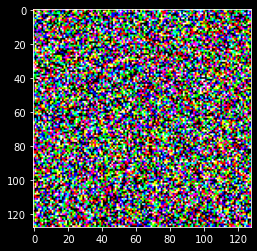

<Figure size 432x288 with 0 Axes>

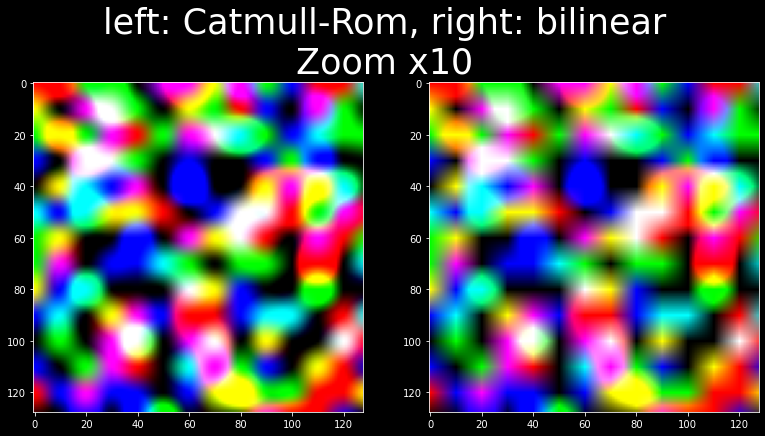

In [13]:
res=tf.reshape(res, [batch_size, h, w, 3])
res2=tf.reshape(res2, [batch_size, h, w, 3])
plt.imshow(imgs[0])
plt.figure()

fig, axs = plt.subplots(1,2,figsize=(13,7))
fig.suptitle('left: Catmull-Rom, right: bilinear\nZoom x'+str(scale), fontsize=35)
axs[0].imshow(res[0])
axs[1].imshow(res2[0])
# notice the cross like behavior of bilinear interpolation